# 1 Delaunay


Assumptions:
<ol>
<li> Symmetric horizontal flight: heading can only change along z/axis (yaw), therefore objects are all placed along the x-y plane (z = 0), so the simulation is reduced to 2D.</li>
<li> Trajectory path calculated according to midpoints of delaunay triangles (basis for Voronoi diagrams).</li>
<li> The radius of the objects is taken into account. The gab between two obstacles and the midpoints are calculated accordingly </li>
<li> In order to prevent obstacles to overlap a constraint is set on min distance between objects, and max radius. Equally, a constraint has to be set on  the beginning position, such that it does not start at the location of a particular interference. 



In [1]:
import numpy as np
import matplotlib.pylab as plt
import time 
%matplotlib inline
import pickle
import scipy 
from scipy.spatial import Delaunay
from numpy import linalg as LA
import matplotlib.pyplot as plt
from graphics import *
#win = GraphWin()
#win.close()

In [2]:
#Load obstaclesm position and heading

with open('initialVariables.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    position, velocity , heading = pickle.load(f)
# with open('obsRotated.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
#     obstacles, __ = pickle.load(f)
with open('obstacles.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    obstacles, __,__,__ = pickle.load(f)

In [3]:
#obtsacles = np.array(obstacles)



In [4]:
# Obstacles, radius, and position
points = np.array(obstacles)[:,0:2]
p = position[0:2]
r = np.array(obstacles) [:,3]
# Heading in cartesian coordinates
head = np.array([np.cos(heading), np.sin(heading)])


In [5]:
# Determine Delanauy triangles, simplices and respective points
tri = Delaunay(points)
median = points[tri.simplices]
# Determine in which triangle point is located
triangle_index = tri.find_simplex(p)
# Extract properties of this triangle, radius, points
points_index = points[tri.simplices[triangle_index]]
radius_index = r[tri.simplices[triangle_index]]
# Add last first element again for loop
rads= np.hstack([radius_index, radius_index[0]])
base = np.vstack([points_index, points_index[0]])


In [6]:

# Estimate median of triangle in which the drone is located
# Median with raidus taken into acount, and median without radius taken into account 
median =np.array([ [
                     base[i], #0 first point [x,y]
                     base[i+1], #1 next point [x,y]
                    LA.norm(   #2 gap with radius scalar
                        np.add(base[i],
                            np.multiply(rads[i],
                                    np.divide(([base[i+1]-base[i]]),
                                             LA.norm([base[i+1]-base[i]]))))
                            -
                        np.add(base[i+1],
                        np.multiply(-rads[i+1],
                                    np.divide(([base[i+1]-base[i]]),
                                             LA.norm([base[i+1]-base[i]]))))),
                    LA.norm([base[i]- base[i+1]]), #3 gap without radius, scalar
                    (np.add(base[i], # 4 midpoint with radius
                            np.multiply(rads[i],
                                    np.divide(([base[i+1]-base[i]]),
                                             LA.norm([base[i+1]-base[i]]))))
                                +
                        np.add(base[i+1],
                        np.multiply(-rads[i+1],
                                    np.divide(([base[i+1]-base[i]]),
                                             LA.norm([base[i+1]-base[i]])))))/2,
                    (base[i]+base[i+1])/2 #5 midpoint without radius
            
                  
                   ]

                  for i in range(len(points_index)) ])



# Gaps



In [81]:
gaps = [med-p for med in median[:,4]]
psi =np.array([np.arctan2(g[0][1],g[0][0]) for g in gaps])
for a,p in enumerate(psi):
     if p<0:
        psi[a]=2*np.pi+p
print(psi, heading)
gaps_heading = np.subtract(psi, heading)
gaps_heading
#psi[a] = [2*np.pi+p for a, p in enumerate(psi) if p<0]
# dx_dy = winner_index[4]-p
# y1 = dx_dy[0]
# psi = np.arctan2(y1[1],y1[0])
# if psi<0:
#     psi = 2*np.pi+psi
# new_heading = psi-heading 
# print(psi, heading, new_heading )

[ 3.16171295  4.58083325  0.75311176] [ 3.0160468]


array([ 0.14566615,  1.56478644, -2.26293505])

# One gap
Winner, largest gap, only take that value

In [37]:
winner_index =median[np.argmax(median[:,2])]
dx_dy = winner_index[4]-p
print(dx_dy[0])
y1 = dx_dy[0]
psi = np.arctan2(y1[1],y1[0])
if psi<0:
    psi = 2*np.pi+psi
new_heading = psi-heading 
print(psi, heading, new_heading )

[ 0.5715592  -0.61896053]
5.45799249731 [ 3.0160468] [ 2.44194569]


In [8]:
with open('heading.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(new_heading, f)

# Sanity check

3
(1, 2)
0.702422473217 [[-1.76585918  0.70242247]]
(1, 2)
-0.61896053453 [[ 0.5715592  -0.61896053]]
(1, 2)
2.19005162052 [[ 2.28596903  2.19005162]]


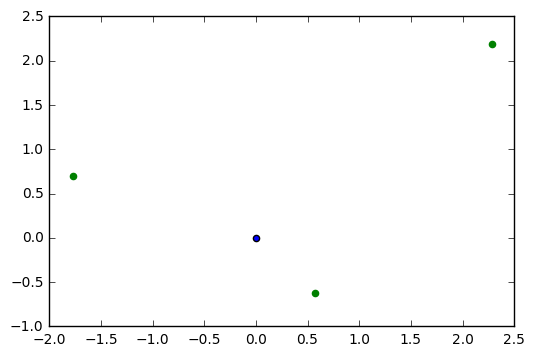

In [9]:

scat = median[:,4]
print(len(scat))
for i in scat:
    print (i.shape)
    print(i[0][1], i)
    x = i[0][0]
    y = i[0][1]

coordinates = np.array([[i[0][0],i[0][1]]for i in scat])
plt.scatter(coordinates[:,0], coordinates[:,1], color = 'g')
plt.scatter(p[0], p[1])
#plt.scatter(scat[:,0],scat[:,1])

3
(1, 2)
0.702422473217 [[-1.76585918  0.70242247]]
(1, 2)
-0.61896053453 [[ 0.5715592  -0.61896053]]
(1, 2)
2.19005162052 [[ 2.28596903  2.19005162]]


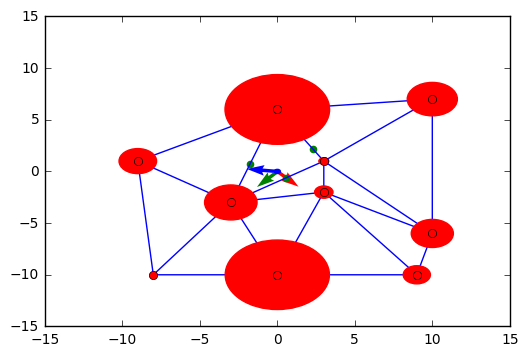

In [10]:
fig, ax = plt.subplots()
limits = 15
ax.set_xlim((-limits, limits))
ax.set_ylim((-limits, limits))
for c in obstacles:
    #print(c)
    point =(c[0],c[1])
    circle = plt.Circle(point, c[3], color='r')
    ax.add_artist(circle)
circle = plt.Circle((p[0],p[1]), 0.2, color='b')
ax.add_artist(circle)

#vec1 = np.multiply(np.ones_like(heading[0:2]),position[0:2])
# vec1 = np.hstack([position[0:2], head[0], head[1]])
# vec1 =np.array([1,1,1,1])
# X, Y, U, V = zip(*vec1)
X,Y,U,V = np.hstack([p[0:2], head[0], head[1]])
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.5, color= 'b')

X,Y,U,V = np.hstack([p[0:2],velocity[0], velocity[1]])
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.5, color= 'g')
X,Y,U,V = np.hstack([p [0:2],np.cos(psi), np.sin(psi)])
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.5, color= 'r')
scat = median[:,4]
print(len(scat))
for i in scat:
    print (i.shape)
    print(i[0][1], i)
    x = i[0][0]
    y = i[0][1]

coordinates = np.array([[i[0][0],i[0][1]]for i in scat])
plt.scatter(coordinates[:,0], coordinates[:,1], color = 'g')


plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')

In [11]:
# import matplotlib.delaunay as triang
# import pylab
# import numpy
# from numpy import linalg as LA

# # 10 random points (x,y) in the plane
# x,y =  numpy.array(numpy.random.standard_normal((2,10)))
# cens,edg,tri,neig = triang.delaunay(x,y)

# for t in tri:
#  # t[0], t[1], t[2] are the points indexes of the triangle
#  t_i = [t[0], t[1], t[2], t[0]]
#  pylab.plot(x[t_i],y[t_i])

# pylab.plot(x,y,'o')
# pylab.show()
#print(x, y, tri, neig)

In [12]:

# points = np.array([[0,0], [0,10],[4,5], [11,-5]])
# r = np.array([0.2,0.5,0.3,0.6])
# r = np.ones(4)*0.5
# tri = Delaunay(points)
# median = points[tri.simplices]
# plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
# plt.plot(points[:,0], points[:,1], 'o')
# r

In [13]:
# triangle_index = tri.find_simplex(p)
# points_index = points[tri.simplices[triangle_index]]
# #tri.simplices[triangle_index]
# radius_index = r[tri.simplices[triangle_index]]
# rads= np.hstack([radius_index, radius_index[0]])
# base = np.vstack([points_index, points_index[0]])

In [14]:


# # for i in range(len(points_index)):
# #     median= (base[i]+base[i+1])/2
# #     print (base[i], base[i+1], median)
    
# median =np.array([ [(base[i]+base[i+1]), 
#                     rads[i]-rads[i+1],
#                     #norm new
#                     LA.norm(np.add([base[i],base[i+1]],np.multiply([rads[i], -rads[i+1]],np.divide(([base[i+1]-base[i]]),LA.norm([base[i+1]-base[i]]))))),
#                     # R times V/V
#                     np.multiply([rads[i], -rads[i+1]],np.divide(([base[i+1]-base[i]]),LA.norm([base[i+1]-base[i]]))),
#                     # Normalised vector
#                     np.divide(([base[i+1]-base[i]]),LA.norm([base[i+1]-base[i]])),
#                     # Vector 
#                     [base[i+1]-base[i]],
#                     # New midpoint
#                     np.divide(base[i]+base[i+1]+np.multiply((rads[i]-rads[i+1]),np.divide(([base[i+1]-base[i]]),LA.norm([base[i+1]-base[i]]))),2),
#                     LA.norm([base[i+1]- base[i]])] 
#                   for i in range(len(points_index)) ])
# median